# Week 7: Autoencoders

Beyond neural networks for classification and regression, there is a world of interesting neural network research with very cool applications. In todays lecture we have talked about *latent spaces* and their importance in
*generative models*. Generative models are, as the name suggests, models which define a procedure for *generating* data that look similar to the trianing data. They learn the underlying structure of the data, a (lower-dimensional) structure that can be explored to obtain new datapoints.

## Exercises

In [ ]:
%matplotlib inline

import os

os.environ["KERAS_BACKEND"] = "tensorflow"

import keras

import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

from tensorflow.keras.datasets import mnist, fashion_mnist
from tensorflow.keras import layers, losses, Input, ops
from tensorflow.keras.layers import Dense, Flatten, Reshape
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import LeakyReLU

### Autoencoders

Autoencoders are a relatively fast to train and interpretable method for compressing data.

> **Ex. 7.1.1**: What is typically the input and output of an autoencoder? What loss function is typically used?

Ans: The input of the autoencoder is the input to the network whether that is a vector representation of an image or other type of data. the output of an autoencoder is the network's best representation of the input from the decompression into the bottleneck and then the reconstruction into the guessed image. The loss function is the squared error between the input and the model's guessed output, representing how close the model's reconstruction of the input is to the actual input.

> **Ex. 7.1.2**: What is the "bottleneck" of an autoencoder? How can you use the autoencoder to encode and decode data once it has been trained?

Ans: The bottleneck is the middle layer of the autoencoder that has a minimal size and contains the compressed data for the inputs. You can use the autoencoder's encoder once it is trained to create compressed representations of inputs which can be sent or transmitted much more efficiently and then on the other end you can use the autoencoder's decoder to interpret that compressed bottleneck representation.

We will be looking at the fashion mnist dataset today which, like the mnist handwritten digits, is comprised of 28x28 grayscale images, but with images of clothing instead. The images are classified according to the following categories

| 0 | 1 | 2 | 3 | 4 | 5 | 6 | 7 | 8 | 9  |
|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-: |
| T-shirt/top  | Trouser  | Pullover  | Dress  | Coat  | Sandal  | Shirt  | Sneaker  | Bag  | Ankle boot |

In the code snippet below we'll plot some random examples from the training data.

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


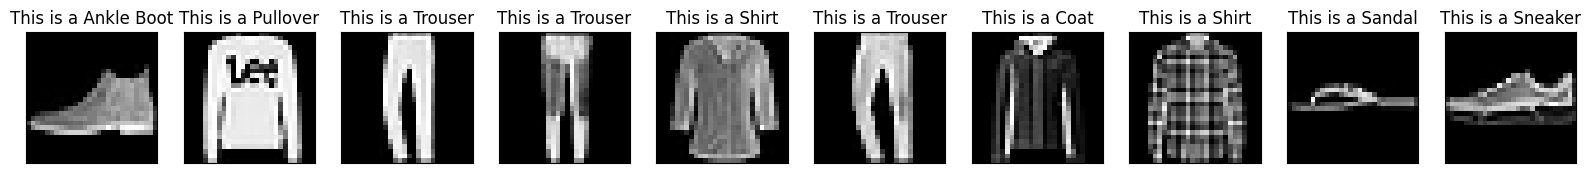

In [ ]:
(x_train, _), (x_test, y_test) = fashion_mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_title('This is a %s' % ({0:'T-shirt/top', 1:'Trouser', 2:'Pullover', 3:'Dress', 4:"Coat", 5:"Sandal", 6:"Shirt", 7:"Sneaker", 8:"Bag", 9:"Ankle Boot"}[y_test[i]]))

Having worked with Keras for a while now, the construction of an autoencoder is simple. Following this [tutorial](https://www.tensorflow.org/tutorials/generative/autoencoder) we construct a subclass of the `keras.models.Model` class called `Autoencoder` that inherits the some methods we want for training (`.compile`, `.fit`) and inference (`.predict`)

In [ ]:
class Autoencoder(Model):
    def __init__(self, latent_dim):
        super(Autoencoder, self).__init__()
        self.latent_dim = latent_dim
        self.encoder = tf.keras.Sequential([
            layers.Flatten(),
            layers.Dense(latent_dim, activation='relu'),
            ])
        self.decoder = tf.keras.Sequential([
            layers.Dense(784, activation='sigmoid'),
            layers.Reshape((28, 28))
            ])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

> **Ex. 7.1.3**: Run the code below to train the autoencoder on the mnist fashion data and visualize it attempting to encode the test data into a latent space and then decode it. How high do you have to go before you can make out the letter "Lee" on the jumper or the plaid/checkered pattern on the shirt?

The original image is 28x28 which is of size 784. so to achieve any compression we need to have a bottleneck latent dimension that is smaller than 784. With very low latent dimensions (<20) we barely get any recognizable image recovery, the shape is right but there is no definition anywhere. With a slighly larger latent dimension of about 100 we get a better definition and can tell there is something on the 'lee' hoodie but cannot tell what the lettering says. Finally, with a size of 225 we can see the 'Lee' on the hoodie and the checker pattern on the shirt.

In [ ]:
autoencoder = Autoencoder(latent_dim = 100)
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError(), metrics=['accuracy'])
history = autoencoder.fit(x_train, x_train,
                epochs=10,
                shuffle=True,
                validation_data=(x_test, x_test))

Epoch 1/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.1027 - loss: 0.0352 - val_accuracy: 0.1819 - val_loss: 0.0111
Epoch 2/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 20s 6ms/step - accuracy: 0.1970 - loss: 0.0102 - val_accuracy: 0.2270 - val_loss: 0.0087
Epoch 3/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 20s 5ms/step - accuracy: 0.2327 - loss: 0.0083 - val_accuracy: 0.2489 - val_loss: 0.0077
Epoch 4/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 23s 7ms/step - accuracy: 0.2524 - loss: 0.0075 - val_accuracy: 0.2621 - val_loss: 0.0073
Epoch 5/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.2615 - loss: 0.0071 - val_accuracy: 0.2653 - val_loss: 0.0070
Epoch 6/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.2664 - loss: 0.0070 - val_accuracy: 0.2693 - val_loss: 0.0069
Epoch 7/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 14s 7ms/step - accuracy: 0.2691 - loss: 0.0068 - val_accuracy: 0.2759 - val_loss: 0.0069
Epoch 8/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 17s 5ms/step - accuracy: 0.2718 - loss: 0

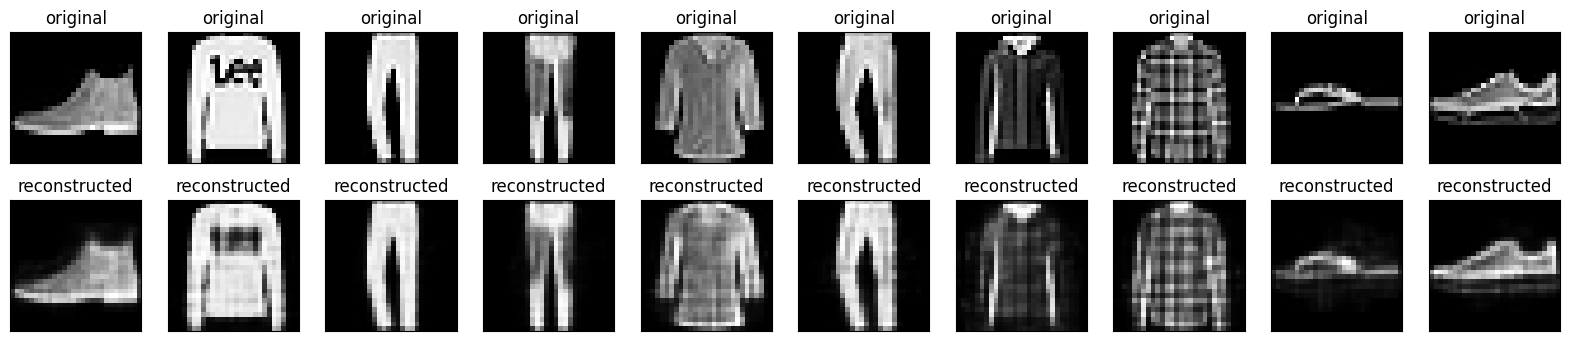

In [ ]:
# Visualization cell
encoded_imgs = autoencoder.encoder(x_test).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i])
    plt.title("original")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i])
    plt.title("reconstructed")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

In [ ]:
autoencoder = Autoencoder(latent_dim = 225)
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError(), metrics=['accuracy'])
history = autoencoder.fit(x_train, x_train,
                epochs=10,
                shuffle=True,
                validation_data=(x_test, x_test))

Epoch 1/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 18s 9ms/step - accuracy: 0.1205 - loss: 0.0303 - val_accuracy: 0.2309 - val_loss: 0.0083
Epoch 2/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 21s 9ms/step - accuracy: 0.2527 - loss: 0.0075 - val_accuracy: 0.2916 - val_loss: 0.0059
Epoch 3/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 18s 8ms/step - accuracy: 0.3035 - loss: 0.0055 - val_accuracy: 0.3226 - val_loss: 0.0049
Epoch 4/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 23s 9ms/step - accuracy: 0.3282 - loss: 0.0047 - val_accuracy: 0.3437 - val_loss: 0.0044
Epoch 5/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 15s 8ms/step - accuracy: 0.3450 - loss: 0.0042 - val_accuracy: 0.3575 - val_loss: 0.0041
Epoch 6/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 22s 9ms/step - accuracy: 0.3563 - loss: 0.0040 - val_accuracy: 0.3626 - val_loss: 0.0040
Epoch 7/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 15s 8ms/step - accuracy: 0.3638 - loss: 0.0038 - val_accuracy: 0.3680 - val_loss: 0.0038
Epoch 8/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 23s 9ms/step - accuracy: 0.3672 - loss: 0

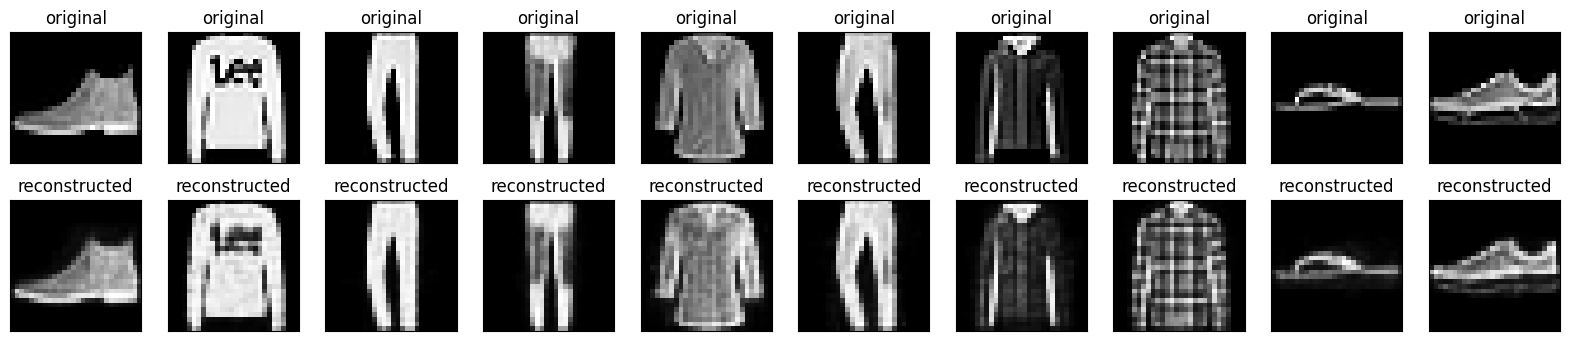

In [ ]:
# Visualization cell
encoded_imgs = autoencoder.encoder(x_test).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i])
    plt.title("original")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i])
    plt.title("reconstructed")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

> **Ex. 7.1.4**: Run the experiment using different values of `latent_dim` (e.g. `[2,16,64,128,512]`) and store the validation loss of the last iteration in the `history` variable for each. Then plot it, my plot looks [like this](https://dhsvendsen.github.io/images/latentdim_vs_reconerror.png).

In [ ]:
latent_dims = [2,16,64,128,512]
val_losses = []

for latent_dim in latent_dims:
    autoencoder = Autoencoder(latent_dim = latent_dim)
    autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError(), metrics=['accuracy'])
    history = autoencoder.fit(x_train, x_train,
                    epochs=10,
                    shuffle=True,
                    validation_data=(x_test, x_test))
    val_loss = history.history['val_loss'][-1]
    val_losses.append(val_loss)
    print("\nTest with %i latent dimension achieved validation loss of %.4f\n\n" % (latent_dim, val_loss))


Epoch 1/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.0514 - loss: 0.0827 - val_accuracy: 0.0664 - val_loss: 0.0575
Epoch 2/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.0694 - loss: 0.0560 - val_accuracy: 0.0699 - val_loss: 0.0504
Epoch 3/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.0676 - loss: 0.0494 - val_accuracy: 0.0607 - val_loss: 0.0460
Epoch 4/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.0622 - loss: 0.0456 - val_accuracy: 0.0586 - val_loss: 0.0446
Epoch 5/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 17s 4ms/step - accuracy: 0.0602 - loss: 0.0447 - val_accuracy: 0.0586 - val_loss: 0.0443
Epoch 6/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.0598 - loss: 0.0444 - val_accuracy: 0.0577 - val_loss: 0.0443
Epoch 7/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.0600 - loss: 0.0443 - val_accuracy: 0.0624 - val_loss: 0.0441
Epoch 8/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.0614 - loss: 0.0442

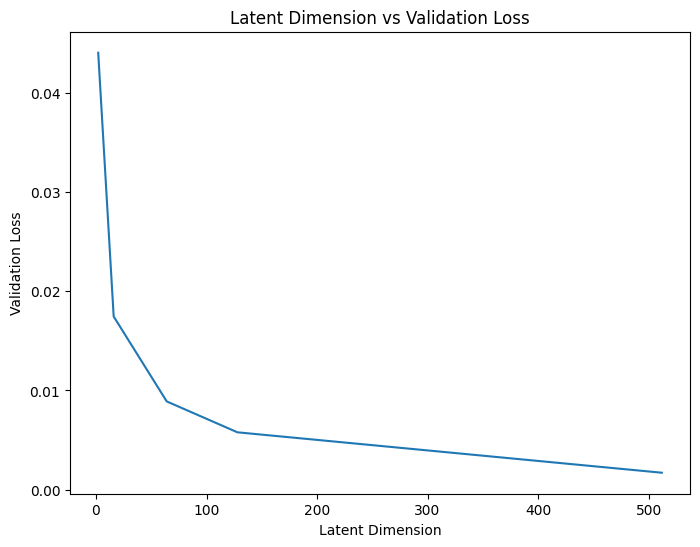

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(latent_dims, val_losses)
plt.title('Latent Dimension vs Validation Loss')
plt.xlabel('Latent Dimension')
plt.ylabel('Validation Loss')
plt.show()

Here we see a similar plot as provided where increasing the latent dimensions decreases the validation loss.

> **Ex. 7.1.5**: Set the `latent_dim = 2` and describe what happens to the test data - what do you think happens to the sandal? Then plot the representation of the test data in the latent space, colouring each point according to its class and describe what you see. [Example plot](https://dhsvendsen.github.io/images/two_latent_dims_simple.png).

In [ ]:
autoencoder = Autoencoder(latent_dim = 2)
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError(), metrics=['accuracy'])
history = autoencoder.fit(x_train, x_train,
                epochs=10,
                shuffle=True,
                validation_data=(x_test, x_test))

Epoch 1/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.0506 - loss: 0.0858 - val_accuracy: 0.0671 - val_loss: 0.0556
Epoch 2/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.0693 - loss: 0.0541 - val_accuracy: 0.0643 - val_loss: 0.0491
Epoch 3/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.0644 - loss: 0.0481 - val_accuracy: 0.0599 - val_loss: 0.0458
Epoch 4/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.0608 - loss: 0.0455 - val_accuracy: 0.0612 - val_loss: 0.0447
Epoch 5/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.0602 - loss: 0.0445 - val_accuracy: 0.0649 - val_loss: 0.0444
Epoch 6/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.0607 - loss: 0.0445 - val_accuracy: 0.0623 - val_loss: 0.0444
Epoch 7/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.0615 - loss: 0.0446 - val_accuracy: 0.0633 - val_loss: 0.0443
Epoch 8/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.0613 - loss: 0.0443 -

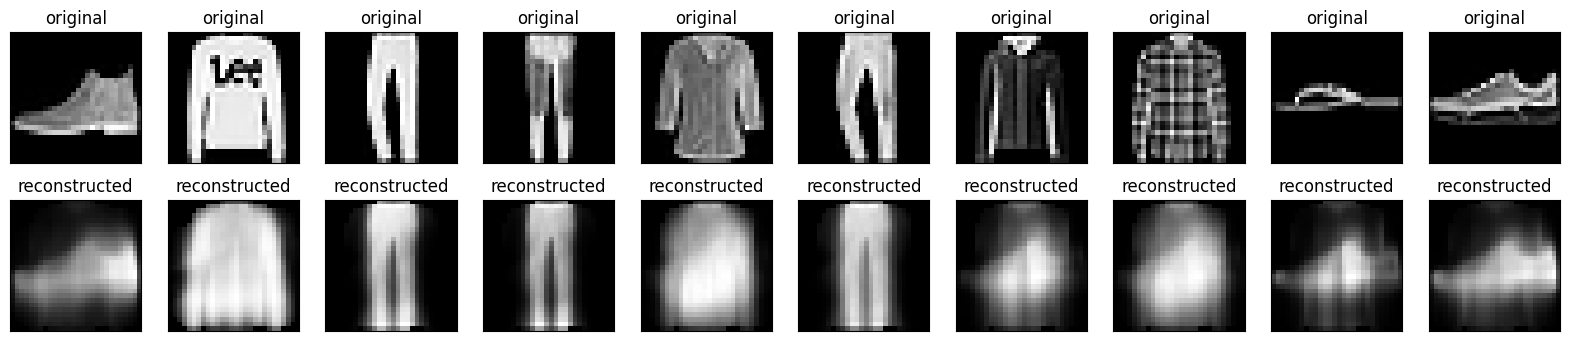

In [ ]:
# Visualization cell
encoded_imgs = autoencoder.encoder(x_test).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i])
    plt.title("original")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i])
    plt.title("reconstructed")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

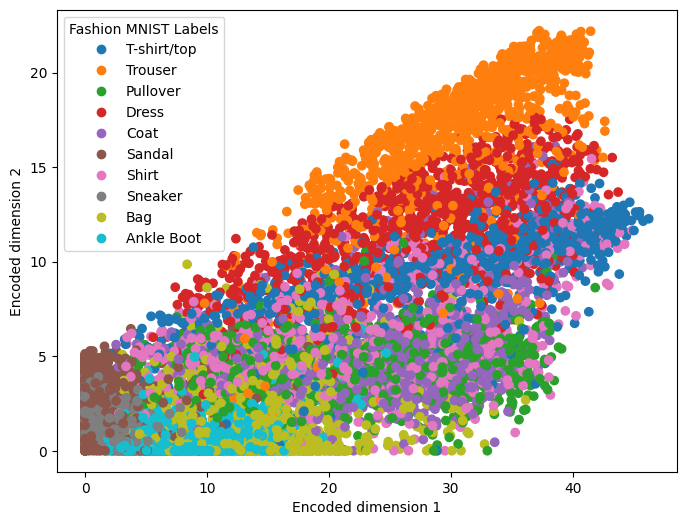

In [ ]:
plt.figure(figsize=(8, 6))
scatter = plt.scatter(encoded_imgs[:, 0], encoded_imgs[:, 1], c=y_test, cmap='tab10')
legend1 = plt.legend(*scatter.legend_elements(), title="Fashion MNIST Labels")  #generates legend elements from y_test options

# set labels for legend
labels = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot']
for i, text in enumerate(legend1.get_texts()):
    text.set_text(labels[i])

plt.xlabel("Encoded dimension 1")
plt.ylabel("Encoded dimension 2")
plt.show()

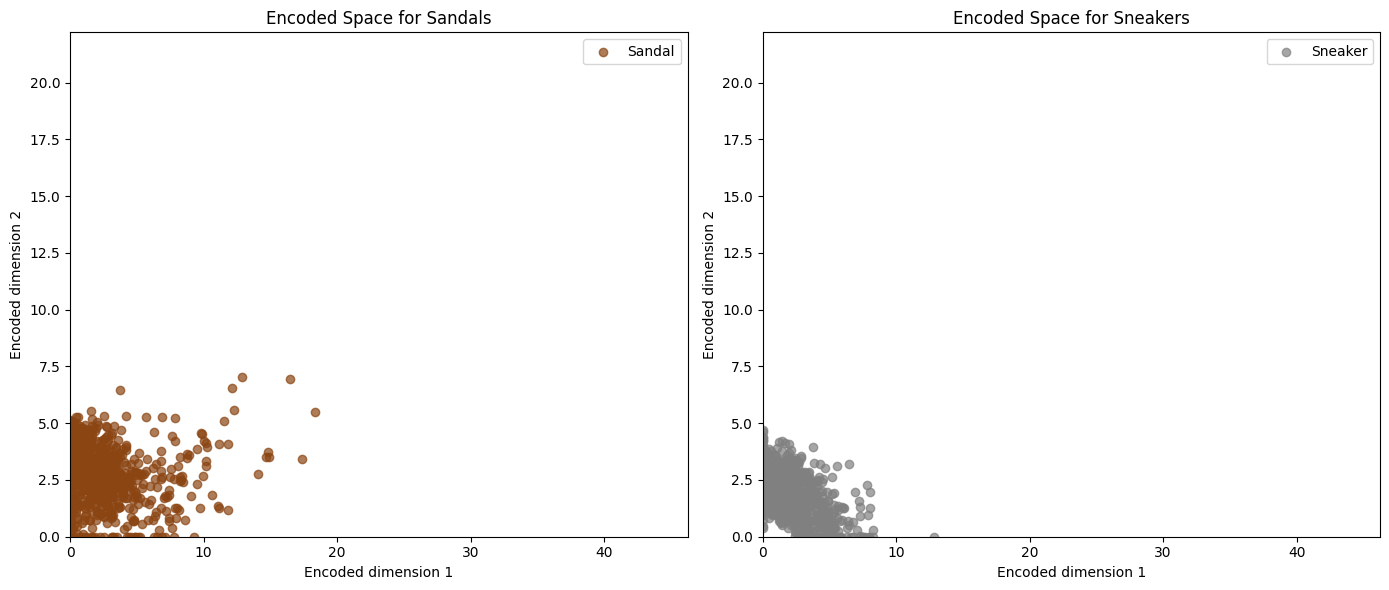

In [ ]:
# find sandal and sneaker
sandal_idx = y_test == 5
sneaker_idx = y_test == 7

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Sandal
ax1.scatter(encoded_imgs[sandal_idx, 0], encoded_imgs[sandal_idx, 1],
            c='#8B4513', label='Sandal', alpha=0.7)
ax1.set_title("Encoded Space for Sandals")
ax1.set_xlabel("Encoded dimension 1")
ax1.set_ylabel("Encoded dimension 2")
ax1.legend()


# Sneaker
ax2.scatter(encoded_imgs[sneaker_idx, 0], encoded_imgs[sneaker_idx, 1],
            c='gray', label='Sneaker', alpha=0.7)
ax2.set_title("Encoded Space for Sneakers")
ax2.set_xlabel("Encoded dimension 1")
ax2.set_ylabel("Encoded dimension 2")
ax2.legend()

# same axis sizes as above for easy comparison
x_limits = [min(np.min(encoded_imgs[:, 0]), np.min(encoded_imgs[:, 0])),
            max(np.max(encoded_imgs[:, 0]), np.max(encoded_imgs[:, 0]))]
y_limits = [min(np.min(encoded_imgs[:, 1]), np.min(encoded_imgs[:, 1])),
            max(np.max(encoded_imgs[:, 1]), np.max(encoded_imgs[:, 1]))]
ax1.set_xlim(x_limits)
ax2.set_xlim(x_limits)
ax1.set_ylim(y_limits)
ax2.set_ylim(y_limits)

plt.tight_layout()
plt.show()

Ans: Here we can see with the graphs above which show the encoded vectors for sneakers and sandals separately but plotted on the same labels. We can also see that the representation in the latent space for sandal and sneaker are very much overlapping and this means that the model with only two latent space variables, the model cannot understand the difference between a sandal and a sneaker. Thus the reconstructed image of a sandal looks very much like a sneaker.And we believe the reason for the model to replicate more close to sneaker as opposed to sandals despite equal number of training images for both is that sneakers are more homogeneous and thus the patter is easier to learn.

Ans: When representing the latent space with only two variables, not much information can be preserved. Thus, it takes the sandal image and compresses it as best as possible, learning from all the other images it is given what other images it is similar to. So, it sees that the sandal looks very similar as the shoes and it seems that the compressed representation for sandals and shoes are basically the same, a blurry shoe shape.

> **Ex. 7.1.6**: It appears that the encoding and decoding scheme is not very effective! Add an extra `Dense` layer of `128` neurons (or more) with `activation='relu'` to both the encoder and the decoder; plot the reconstructions of the test images again. We are cramming all the information of 784 pixels into a 2-dimensional vector space - lets see if there is a way to do it which retains key information. Plot the 2-D latent representation of the test data again. Using this ([Example](https://dhsvendsen.github.io/images/two_latent_dims_ordered.png)) plot, explain why our reconstruction error is lower.

In [ ]:
class DenseAutoencoder(Model):
    def __init__(self, latent_dim):
        super(DenseAutoencoder, self).__init__()
        self.latent_dim = latent_dim
        self.encoder = tf.keras.Sequential([
            layers.Flatten(),
            layers.Dense(128, activation = 'relu'),
            layers.Dense(latent_dim, activation='relu'),
            ])
        self.decoder = tf.keras.Sequential([
            layers.Dense(128, activation = 'relu'),
            layers.Dense(784, activation='sigmoid'),
            layers.Reshape((28, 28))
            ])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [ ]:
Denseautoencoder = DenseAutoencoder(latent_dim = 2)
Denseautoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError(), metrics=['accuracy'])
history = Denseautoencoder.fit(x_train, x_train,
                epochs=10,
                shuffle=True,
                validation_data=(x_test, x_test))

Epoch 1/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - accuracy: 0.0624 - loss: 0.0563 - val_accuracy: 0.0813 - val_loss: 0.0364
Epoch 2/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.0813 - loss: 0.0363 - val_accuracy: 0.0897 - val_loss: 0.0342
Epoch 3/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 20s 6ms/step - accuracy: 0.0874 - loss: 0.0340 - val_accuracy: 0.0991 - val_loss: 0.0333
Epoch 4/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 20s 6ms/step - accuracy: 0.0907 - loss: 0.0333 - val_accuracy: 0.0890 - val_loss: 0.0333
Epoch 5/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.0917 - loss: 0.0324 - val_accuracy: 0.0933 - val_loss: 0.0315
Epoch 6/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step - accuracy: 0.0918 - loss: 0.0316 - val_accuracy: 0.0958 - val_loss: 0.0311
Epoch 7/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 19s 5ms/step - accuracy: 0.0938 - loss: 0.0309 - val_accuracy: 0.0943 - val_loss: 0.0302
Epoch 8/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.0949 - loss: 0

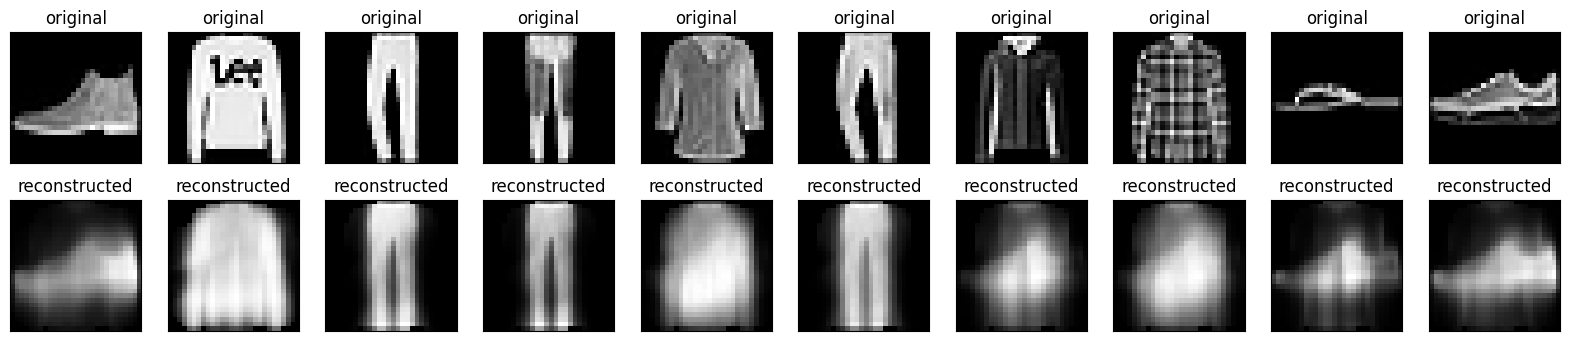

In [ ]:
# Visualization cell
dense_encoded_imgs = Denseautoencoder.encoder(x_test).numpy()
dense_decoded_imgs = Denseautoencoder.decoder(encoded_imgs).numpy()

n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i])
    plt.title("original")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i])
    plt.title("reconstructed")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

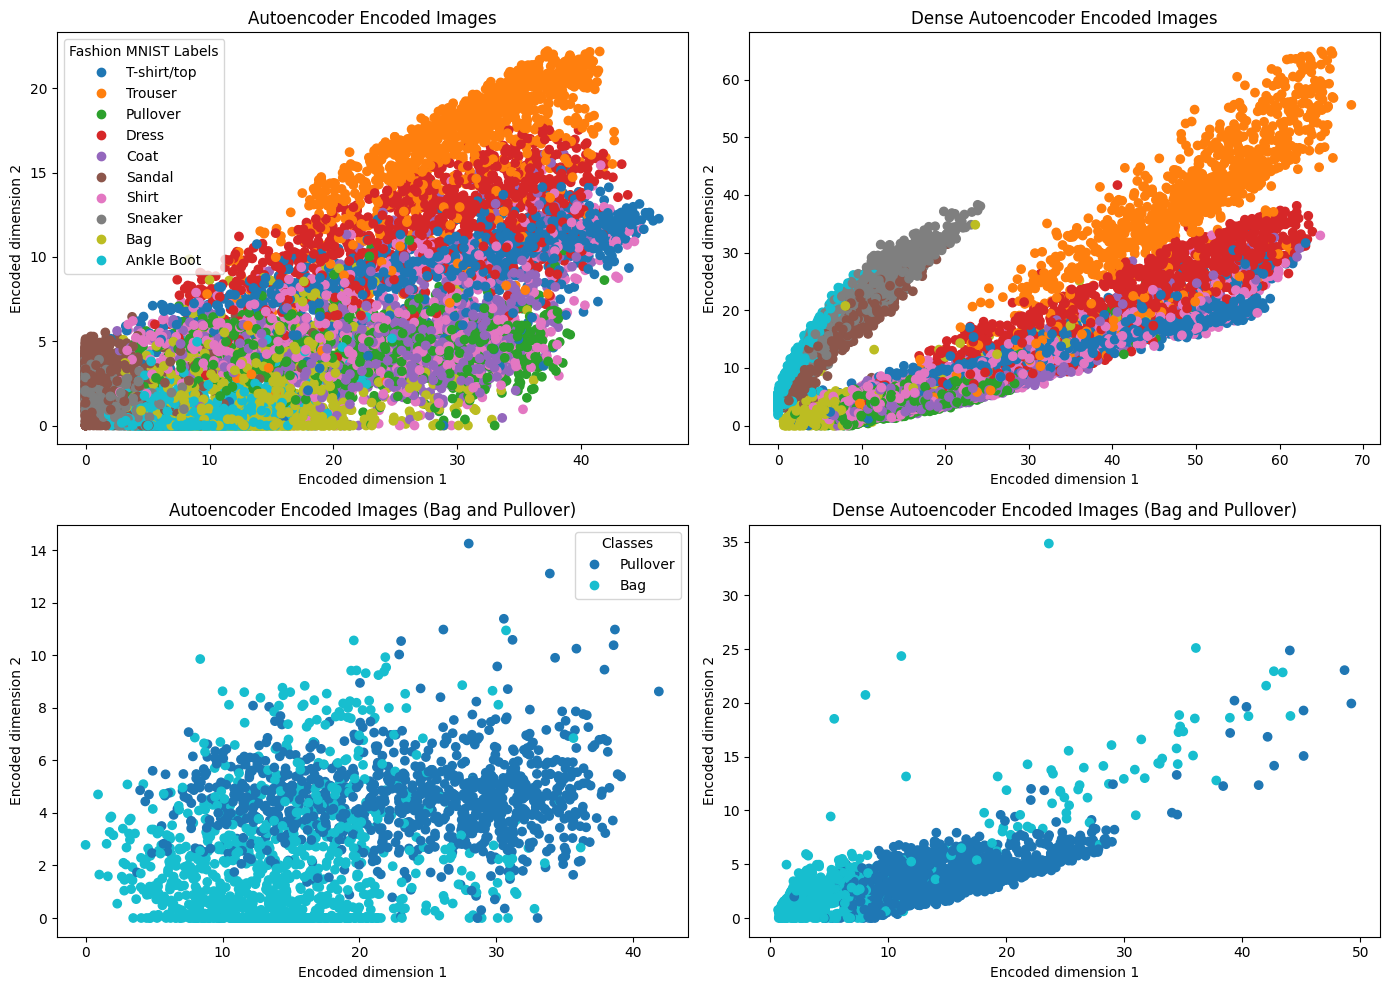

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(14, 10))

# Autoencoder
scatter1 = axs[0, 0].scatter(encoded_imgs[:, 0], encoded_imgs[:, 1], c=y_test, cmap='tab10')
axs[0, 0].set_title("Autoencoder Encoded Images")
axs[0, 0].set_xlabel("Encoded dimension 1")
axs[0, 0].set_ylabel("Encoded dimension 2")

# Dense encoder
scatter2 = axs[0, 1].scatter(dense_encoded_imgs[:, 0], dense_encoded_imgs[:, 1], c=y_test, cmap='tab10')
axs[0, 1].set_title("Dense Autoencoder Encoded Images")
axs[0, 1].set_xlabel("Encoded dimension 1")
axs[0, 1].set_ylabel("Encoded dimension 2")



# bag and pullover
bag_pullover_indices = np.where((y_test == 8) | (y_test == 2))[0]

scatter3 = axs[1, 0].scatter(encoded_imgs[bag_pullover_indices, 0], encoded_imgs[bag_pullover_indices, 1], c=y_test[bag_pullover_indices], cmap='tab10')
axs[1, 0].set_title("Autoencoder Encoded Images (Bag and Pullover)")
axs[1, 0].set_xlabel("Encoded dimension 1")
axs[1, 0].set_ylabel("Encoded dimension 2")

scatter4 = axs[1, 1].scatter(dense_encoded_imgs[bag_pullover_indices, 0], dense_encoded_imgs[bag_pullover_indices, 1], c=y_test[bag_pullover_indices], cmap='tab10')
axs[1, 1].set_title("Dense Autoencoder Encoded Images (Bag and Pullover)")
axs[1, 1].set_xlabel("Encoded dimension 1")
axs[1, 1].set_ylabel("Encoded dimension 2")



legend1 = axs[0, 0].legend(*scatter1.legend_elements(), title="Fashion MNIST Labels")

# set labels for legend
labels = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot']
for i, text in enumerate(legend1.get_texts()):
    text.set_text(labels[i])

legend1 = axs[1, 0].legend(*scatter3.legend_elements(), title="Classes")

labels = ['Pullover', 'Bag']
for i, text in enumerate(legend1.get_texts()):
    text.set_text(labels[i])



plt.tight_layout()
plt.show()

Ans: Our reconstruction error is much lower after adding the dense layers because we are creating a deeper network which is able to differentiate between the classes better. We can see this above when comparing the two graphs as without the dense layer the classes are all clustered together. Notice that the light green 'Bag' class and the dark green 'Pullover' class are overlapping significantly in the autoencoder graph but are more clearly separated in the dense autoencoder graph. Still, we are only using two variables to encode the images and thus we are getting only decent reconstructions and there is still a lot of overlapping.

#

# Variational Autoencoders

We expand the Autoencoder network to be able to learn a probability distrubtion over the encoded data representation. In this way we can generate new examples by sampling the learned distribution.

We will go about this by forcing a prior probability on the latent variable $\textbf{z}$, assuming it to be a normal distribution $p(\textbf{z}) \sim \mathcal{N}(\textbf{0}, \textbf{I})$.
We can then model the data generation process through the likelihood $p_\theta(\textbf{x}|\textbf{z})$ which is parametrized by the decoder network. In practical terms, this means that a new observation (datapoint) can be generated by taking a sample from the latent variable and propagating it through the decoder.

We will take a closer look at the VAE architecture by investigating all of its individual components. Just to spice it up a little, we will consider a VAE using convolutional layers. Starting from the decoder, you can see how it works exactly like the decoder from a normal Autoencoder: each layer "expands" the previous layer's dimensions, going from the bottleneck to an output with matching dimensions to the input data. How this is done is easy to understand for dense layers, but it is a bit more complex for convolutional layers.

In [ ]:
# Decoder network
latent_dim = 2  # the dimensionality of the latent space

latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(7 * 7 * 64, activation="relu")(latent_inputs)
x = layers.Reshape((7, 7, 64))(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_20 (InputLayer)          │ (None, 2)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_22 (Dense)                     │ (None, 3136)                │           9,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_10 (Reshape)                 │ (None, 7, 7, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose (Conv2DTranspose)   │ (None, 14, 14, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_1 (Conv2DTranspose) │ (None, 28, 28, 32)          │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_2 (Conv2DTranspose) │ (None, 28, 28, 1)           │             289 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 65,089 (254.25 KB)

 Trainable params: 65,089 (254.25 KB)

 Non-trainable params: 0 (0.00 B)

The complex part about VAEs is to understand how to get from defining the data generation process as a sampling procedure to learning a latent probability distribution.

The gist is that, when training our network, we want to learn both a good posterior distribution $p_\theta(\textbf{z}|\textbf{x})$ (i.e. we want a latent representation that models well the evidence) while maintaining a good likelihood $p_\theta(\textbf{z}|\textbf{x})$ (i.e. how accurate is our data reconstruction after sampling the latent space). Doing this directly is impossible since the posterior $p_\theta(\textbf{z}|\textbf{x})$ is intractable, so we will instead _approximate_ it through another distribution $q_\phi (\textbf{z}|\textbf{x})$ (which we will also assume to be normally distributed), this time parametrized by the decoder.

In practice, the way to tie this up together is to have the encoder network produce the parameters of the Gaussian distribution (namely a mean and a variance vector) which then are used to sample the latent variable $\textbf{z}$. We have to first define a custom sampling layer, which will take as input the mean and variance vectors learned by the encoder and output a sample from an accordingly distributed Gaussian distribution.

In [ ]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.seed_generator = keras.random.SeedGenerator(1337)

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = ops.shape(z_mean)[0]
        dim = ops.shape(z_mean)[1]
        epsilon = keras.random.normal(shape=(batch, dim), seed=self.seed_generator)
        return z_mean + ops.exp(0.5 * z_log_var) * epsilon


And now we have it! The encoding layer looks much like a normal encoder architecture you have seen so far, but with the sampling layer we just defined at the very end of it.

In [ ]:
#Encoder network

encoder_inputs = Input(shape=(28, 28, 1))
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(16, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()


Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_21            │ (None, 28, 28, 1)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 14, 14, 32)     │            320 │ input_layer_21[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 7, 7, 64)       │         18,496 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_10 (Flatten)      │ (None, 3136)           │              0 │ conv2d_1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_23 (Dense)          │ (None, 16)             │         50,192 │ flatten_10[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ z_mean (Dense)            │ (None, 2)              │             34 │ dense_23[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ z_log_var (Dense)         │ (None, 2)              │             34 │ dense_23[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sampling (Sampling)       │ (None, 2)              │              0 │ z_mean[0][0],          │
│                           │                        │                │ z_log_var[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 69,076 (269.83 KB)

 Trainable params: 69,076 (269.83 KB)

 Non-trainable params: 0 (0.00 B)

Time to put it all together! Note that the VAE itself is not defined as a normal `Sequential` stack of layers: this is because we want to be able to call the encoder and the decoder separately!

encoder learns parameters of the distribution which are zmean and zlog variables. z is the latent space. Assume z is 0-1. z is a latent space normal distribution.

In [ ]:
# Define the VAE network

class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data) #Q1 what are z_mean, z_log_var and z here?
            reconstruction = self.decoder(z) #Q2 what's the output of the decoder layer?
            reconstruction_loss = ops.mean(
                ops.sum(
                    keras.losses.binary_crossentropy(data, reconstruction),
                    axis=(1, 2),
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - ops.square(z_mean) - ops.exp(z_log_var))
            kl_loss = ops.mean(ops.sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss #Q3 the loss is given by two terms here: what are they?
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }


Q1:
Ans: z_mean is the average of that latent variables for a specific image, and z_log_var is the variance of the latent variables for that image, and z is the sampled latent variables from the dristribution constructed by z_mean and z_log_var. This is the reparameterization trick that allows backpropagation.

Q2:
Ans: The output of the decoder layer is an image (one dimensional vector) reconstructed from the sampled latent vector/variables z.

Q3:
Ans: the reconstruction loss is the binary cross entropy loss that is calculated by the pixel value differences for each pixel in the original image and the reconstructed image. The kl_loss is the regularization term that calculates the divergence of the learned latent distribution and standard normal distribution. Minimizing these to combined loss the VAE learns to create a latent distribution that is close to a standard normal distribution and make sure sampled vectors from that distribution can reconstruct images similar to training images.

> **Ex. 7.2.1** In the code above we also define a custom `train_step` for the VAE. Look at the code and how training is done for such an architecture and answer the questions

We will now train our VAE. Five epochs are sufficient to learn a decent enough latent representation to the data to be looked at, but you can play around and let it train for longer to see what changes!

In [ ]:
# Reload dataset
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

# Need to add last dimension for CNN layers
x_train = np.expand_dims(x_train, -1).astype("float32") / 255.
x_test = np.expand_dims(x_test, -1).astype("float32") / 255.

vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())
vae.fit(x_train, epochs=5, batch_size=128)

Epoch 1/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 91s 188ms/step - kl_loss: 4.1806 - loss: 376.3102 - reconstruction_loss: 372.1297
Epoch 2/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 142s 188ms/step - kl_loss: 5.7333 - loss: 276.2834 - reconstruction_loss: 270.5500
Epoch 3/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 142s 188ms/step - kl_loss: 5.8286 - loss: 271.9258 - reconstruction_loss: 266.0972
Epoch 4/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 142s 188ms/step - kl_loss: 5.9155 - loss: 269.8430 - reconstruction_loss: 263.9275
Epoch 5/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 142s 188ms/step - kl_loss: 5.9393 - loss: 268.4700 - reconstruction_loss: 262.5307


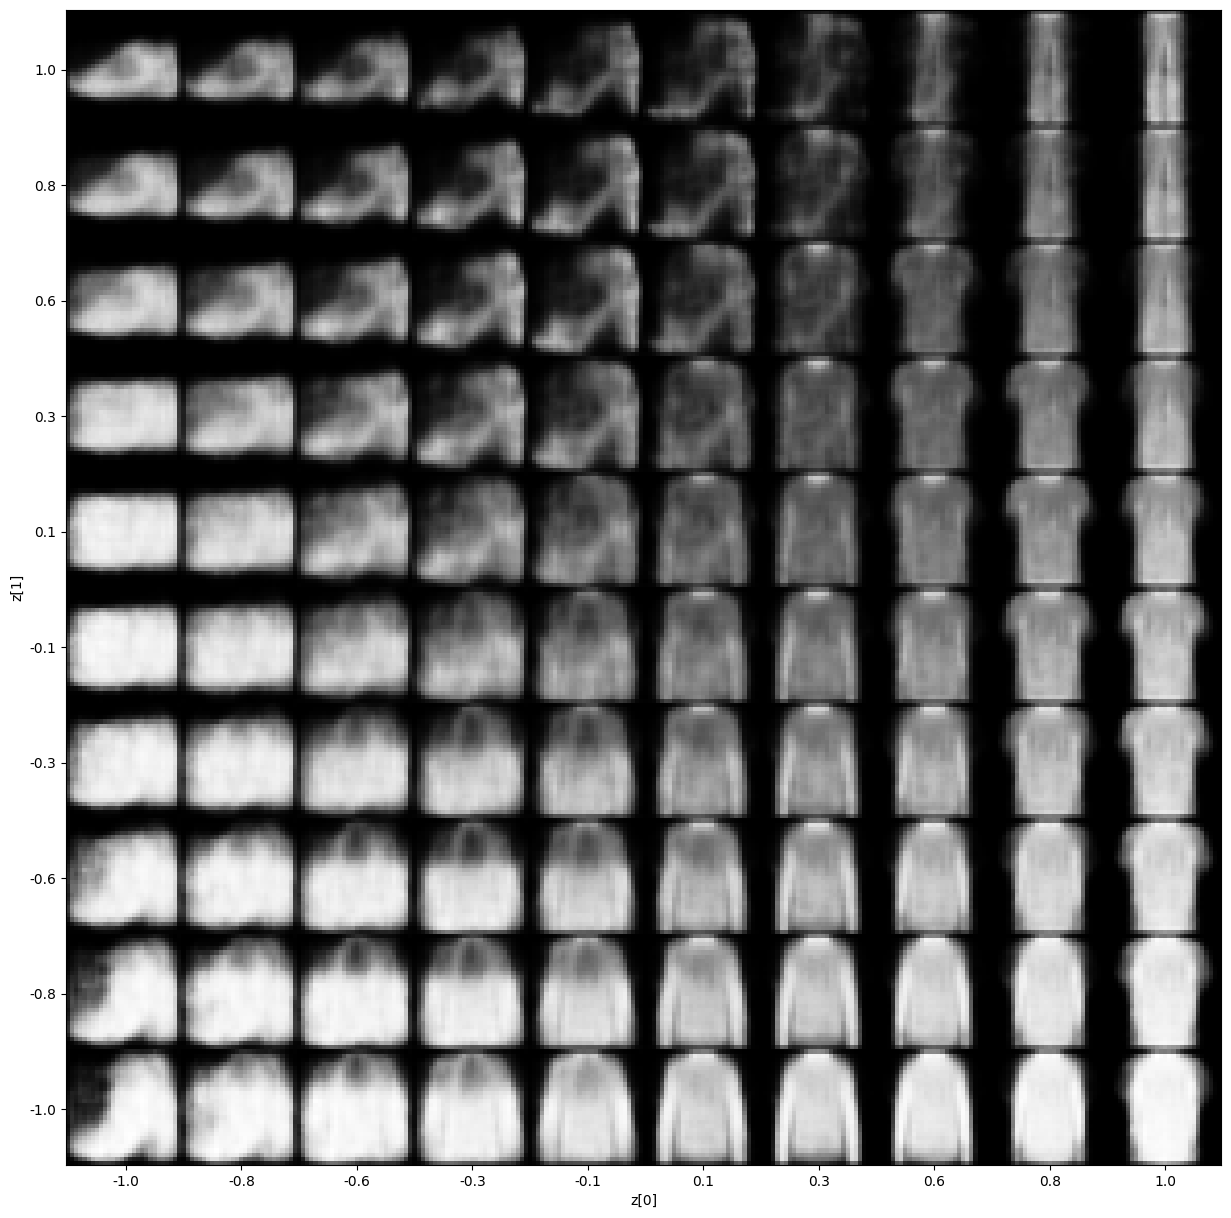

In [ ]:
def plot_latent_space(vae, n=10, figsize=15, imgsize=28):
    # display a n*n 2D manifold of fashion-MNIST images
    scale = 1.0
    figure = np.zeros((imgsize * n, imgsize * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = vae.decoder.predict(z_sample, verbose=0)
            fashionmnist_img = x_decoded[0].reshape(imgsize, imgsize)
            figure[
                i * imgsize : (i + 1) * imgsize,
                j * imgsize : (j + 1) * imgsize,
            ] = fashionmnist_img

    plt.figure(figsize=(figsize, figsize))
    start_range = imgsize // 2
    end_range = n * imgsize + start_range
    pixel_range = np.arange(start_range, end_range, imgsize)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()


plot_latent_space(vae)

> **Ex. 7.2.2** In the code above we generated new data new data using the learned latent representation.
> - What are the points in `grid_x` and `grid_y`?
> - How is a sample in the latent space transformed in a new image?

Ans: grid_x is array of linearly spaced x values in the 2D latent space of the VAE. And grid_y is linearly spaced y values starting from the end of the grid in the 2D latent space of the VAE. Together they are used to create sampled reconstruction from the latent space linearly spaced from top to bottom in the graph above.

Ans: A sample in the latent space is transformed using the decoder into a new image. Also by shifting around the sample slightly in the latent space can generate new images that are not merely reconstruction of the encoded training images with the help of decoder. In the code first z_sample is created by taking xi and yi from grid_x and grid_y then using the decoder z_sample is transformed into an image_vector x_decoded. And lastly, x_decoded is reshaped into an image matrix and plotted as an image.

<ipython-input-41-054fc9d2dbf4>:9: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(xi, yi, c=colors[i], label=str(u))


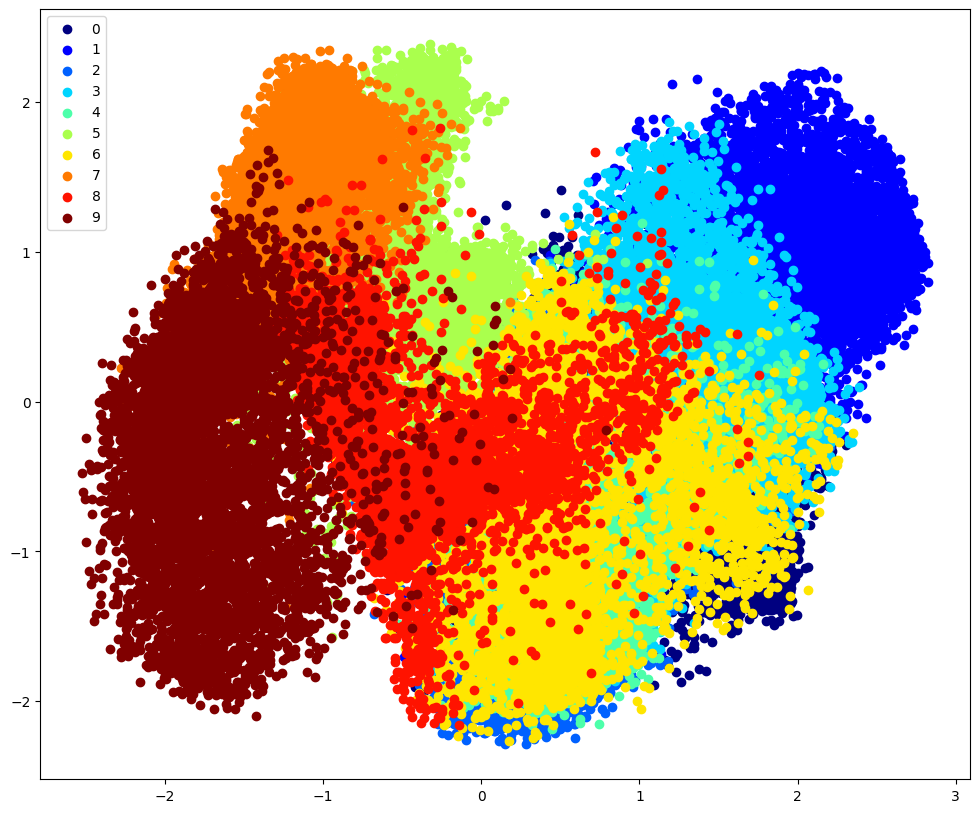

In [ ]:
z_mean, _, _ = vae.encoder.predict(x_train, verbose=0)

plt.figure(figsize=(12, 10))
unique = list(set(y_train))
colors = [plt.cm.jet(float(i)/max(unique)) for i in unique]
for i, u in enumerate(unique):
    xi = [z_mean[:, 0][j] for j  in range(len(z_mean)) if y_train[j] == u]
    yi = [z_mean[:, 1][j] for j  in range(len(z_mean)) if y_train[j] == u]
    plt.scatter(xi, yi, c=colors[i], label=str(u))
plt.legend()

plt.show()

> **Ex. 7.2.3**: Look at the encoding of the training set learned by our VAE and compare it to the one learned by the non-variational AE of Exercise 7.1.6. Can you highlight some key differences in how the encoded data is distributed?
>
> Remember that for the comparison to be meaningful, the latent space dimensionality `latent_dim` should be the same for both architectures.

Ans: In exercise 7.1.6 the encoded data for AE were distributed in a non normal distribution were some categories of images had larger distribution than the others. But the encoded distribution of the VAE is significantly more normal for each category of images and at that same time the distribution of each category of image is somewhat closer is size. This results in the encoded values being in all four quadrants as opposed to only the first quadrant in the AE latent distribution.